Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from helpers import wrangle_backtest
from statsmodels.tsa.stattools import adfuller

Loading round 4 data 

In [ ]:
with open("data/round4.log", "r", encoding="utf-8") as f:
    content = f.readlines()

trades_df, activity_logs_df, sandbox_logs = wrangle_backtest(content)

List unique instruments from round 4

In [ ]:
unique_instruments = trades_df['symbol'].unique()

print("Instruments available in round 4:")
for symbol in unique_instruments:
    print("-", symbol)


Instruments available in round 4:
- COCONUT_COUPON
- COCONUT


Coconut and coconut_coupon data

In [11]:
# COCONUT
coconut_df = trades_df[trades_df['symbol'] == 'COCONUT'].copy()
coconut_df['timestamp'] = pd.to_numeric(coconut_df['timestamp'], errors='coerce')
coconut_df = coconut_df.sort_values('timestamp')

print("=== COCONUT trades ===")
print(coconut_df)

# COCONUT_COUPON
coupon_df = trades_df[trades_df['symbol'] == 'COCONUT_COUPON'].copy()
coupon_df['timestamp'] = pd.to_numeric(coupon_df['timestamp'], errors='coerce')
coupon_df = coupon_df.sort_values('timestamp')

print("\n=== COCONUT_COUPON trades ===")
print(coupon_df)


=== COCONUT trades ===
      timestamp       buyer      seller   symbol   currency  price  quantity
13         5200      Vinnie      Vinnie  COCONUT  SEASHELLS   9997         8
19         9300         Raj  SUBMISSION  COCONUT  SEASHELLS  10005         6
23        10900      Vinnie      Vinnie  COCONUT  SEASHELLS  10007        10
24        12500  SUBMISSION         Raj  COCONUT  SEASHELLS  10003         7
25        12500      Vinnie         Raj  COCONUT  SEASHELLS  10003         3
...         ...         ...         ...      ...        ...    ...       ...
5178    2994900      Vinnie      Vinnie  COCONUT  SEASHELLS   9885         9
5179    2995500      Vinnie      Vinnie  COCONUT  SEASHELLS   9887         8
5181    2997100      Vinnie      Vinnie  COCONUT  SEASHELLS   9885         9
5182    2997200      Vinnie      Vinnie  COCONUT  SEASHELLS   9883         8
5183    2998600      Vinnie         Raj  COCONUT  SEASHELLS   9887         5

[1987 rows x 7 columns]

=== COCONUT_COUPON trades =

Plotting amethysts price through first round

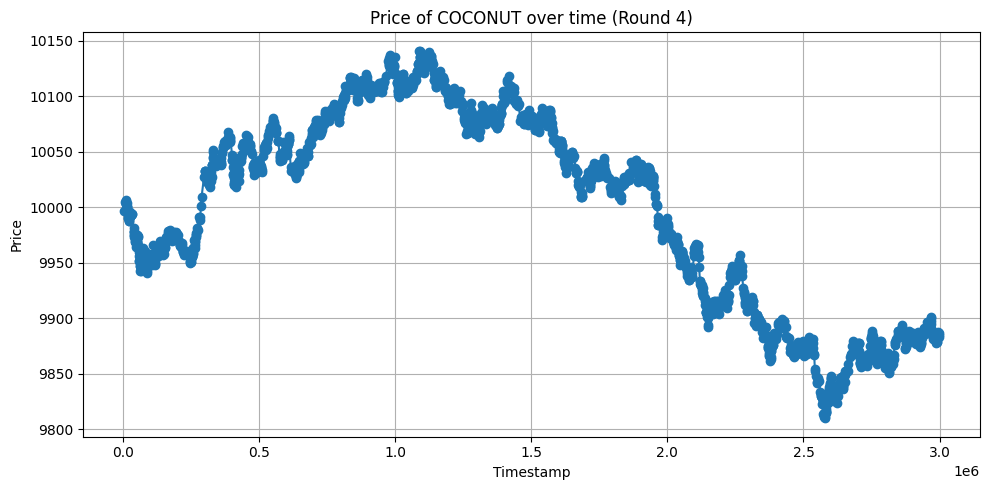

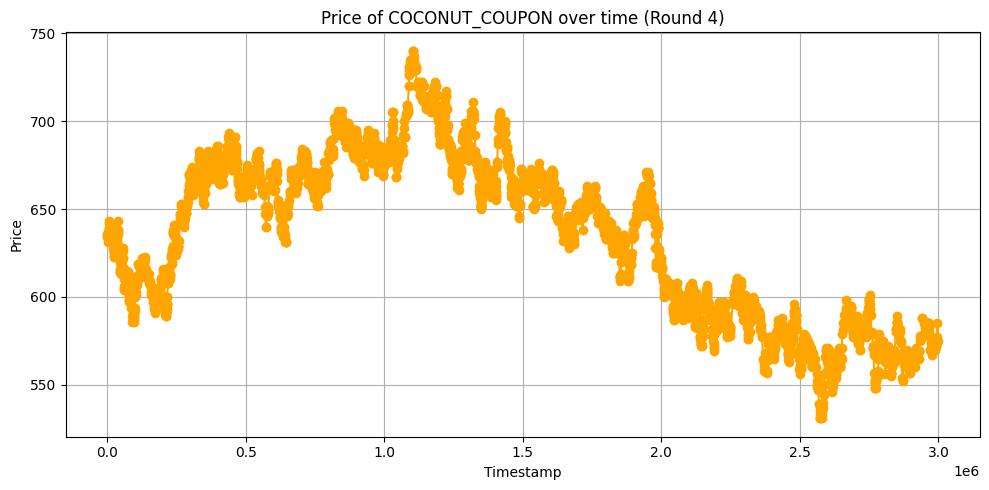

In [12]:
import matplotlib.pyplot as plt

# COCONUT
instrument = 'COCONUT'
instrument_df = trades_df[trades_df['symbol'] == instrument].copy()
instrument_df['timestamp'] = pd.to_numeric(instrument_df['timestamp'], errors='coerce')
instrument_df = instrument_df.sort_values('timestamp')

plt.figure(figsize=(10, 5))
plt.plot(instrument_df['timestamp'], instrument_df['price'], marker='o')
plt.title(f"Price of {instrument} over time (Round 4)")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()

# COCONUT_COUPON
instrument = 'COCONUT_COUPON'
instrument_df = trades_df[trades_df['symbol'] == instrument].copy()
instrument_df['timestamp'] = pd.to_numeric(instrument_df['timestamp'], errors='coerce')
instrument_df = instrument_df.sort_values('timestamp')

plt.figure(figsize=(10, 5))
plt.plot(instrument_df['timestamp'], instrument_df['price'], marker='o', color='orange')
plt.title(f"Price of {instrument} over time (Round 4)")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()



Conclusions:

COCONUT_COUPON shows greater relative price swings (from ~540 to ~740) compared to COCONUT (from ~9800 to ~10100).

This makes sense if COUPON is an option — options are generally more sensitive to changes in the underlying (i.e. higher gamma/vega).

Correlation analysis

In [13]:
merged = pd.merge_asof(
    coconut_df.sort_values("timestamp"),
    coupon_df.sort_values("timestamp"),
    on="timestamp",
    direction="nearest",
    suffixes=("_coconut", "_coupon")
)

correlation = merged["price_coconut"].corr(merged["price_coupon"])
print(f"📈 Correlation: {correlation:.4f}")


📈 Correlation: 0.9575


A high value close to +1 confirms that COCONUT_COUPON follows the base asset closely.

Linear regression (OLS)

COCONUT_COUPON ~ a * COCONUT + b

In [14]:
import statsmodels.api as sm

X = merged["price_coconut"]
y = merged["price_coupon"]
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           price_coupon   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                 2.185e+04
Date:                Mon, 26 May 2025   Prob (F-statistic):               0.00
Time:                        18:07:07   Log-Likelihood:                -7989.8
No. Observations:                1987   AIC:                         1.598e+04
Df Residuals:                    1985   BIC:                         1.599e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4398.4582     34.049   -129.182

Key takeaways

1. R-squared = 0.917
91.7% of the variance in COCONUT_COUPON is explained by COCONUT.
This is very high and confirms a strong linear relationship — expected, as COCONUT_COUPON behaves like a derivative of COCONUT.

2. Slope (coefficient for price_coconut) = 0.5033
Interpretation: for every 1-point change in the price of COCONUT, the COCONUT_COUPON price moves by ~0.50 points.
This resembles the delta of a call option, which often starts near 0.5.

